# MRNet: Project Utility first
## Author: Mirko Lantieri
**Python Notebook** : utilized for facility in data exploration, visualization etc.

## Interactive view of all the available data

In [1]:
from IPython.core.display import HTML
HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>')

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('./images/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()    
# train-acl.csv and valid-acl.csv have the same structure with two colums

,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [2]:
# Shape
print(train_acl.shape)
train_acl.Abnormal.value_counts(normalize=True) # normalization of the data

(1130, 2)


0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [3]:
# 3 Plane persepective
case = '0000'

mri_coronal = np.load('./images/train/coronal/0000.npy')
mri_axial = np.load('./images/train/axial/0000.npy')
mri_sagittal = np.load('./images/train/sagittal/0000.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


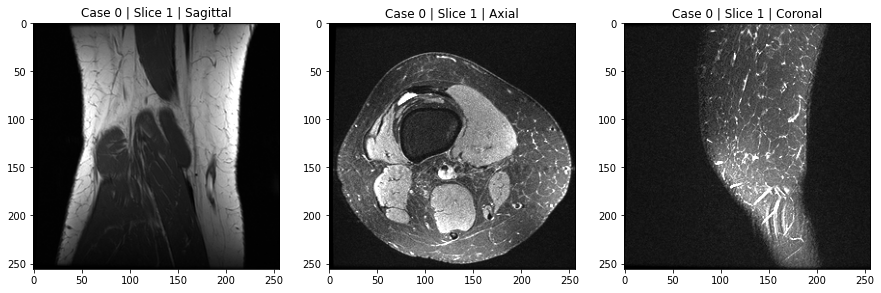

In [4]:
# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');

In [5]:
train_path = './images/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('./images/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('./images/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=417)

<ipython-input-5-a435c38bd942>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for case in tqdm_notebook(case_list, leave=False):


  0%|          | 0/417 [00:00<?, ?it/s]

In [6]:
print(cases['0000']['axial'].shape)
print(cases['0000']['coronal'].shape)
print(cases['0000']['sagittal'].shape)

(44, 256, 256)
(36, 256, 256)
(36, 256, 256)


In [7]:
# Class KneePlot that creates the interactive plot from the cases object.
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
    
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [8]:
plot = KneePlot(cases)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…

## Data loading

In [9]:
import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

class MRData():
    
    def __init__(self, root_dir='./images/'):
        self.root_dir = root_dir

    def merge_csv(self, file):
        if file == 'train':
            print('Reading into train folder')
            train_acl = pd.read_csv((self.root_dir+'train-acl.csv'), header=None, names=['case', 'acl'], dtype={'case': str, 'acl': np.int64})
            train_abnormal = pd.read_csv((self.root_dir+'train-abnormal.csv'), header=None, names=['case', 'abnormal'], dtype={'case': str, 'acl': np.int64})
            train_men = pd.read_csv((self.root_dir+'train-meniscus.csv'), header=None, names=['case', 'meniscus'], dtype={'case': str, 'acl': np.int64})

            train_df = pd.merge(train_abnormal, train_acl, on='case').merge(train_men, on='case')
            print('\nMissing values train-df: ', train_df.isnull().values.any())
            print(train_df)
            
            return train_df

        elif file == 'valid':
            print('Reading into train folder')
            valid_acl = pd.read_csv((self.root_dir+'valid-acl.csv'), header=None, names=['case', 'acl'], dtype={'case': str, 'acl': np.int64})
            valid_abnormal = pd.read_csv((self.root_dir+'valid-abnormal.csv'), header=None, names=['case', 'abnormal'], dtype={'case': str, 'acl': np.int64})
            valid_men = pd.read_csv((self.root_dir+'valid-meniscus.csv'), header=None, names=['case', 'meniscus'], dtype={'case': str, 'acl': np.int64})

            val_df = pd.merge(valid_abnormal, valid_acl, on='case').merge(valid_men, on='case')
            print('\nMissing values train-df: ', val_df.isnull().values.any())
            print(val_df)

            return val_df

    def load_npy(self, dir, n_case):

        if dir == 'valid/':
            labels_valid = []
            labels_valid_abnormal = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'valid-abnormal.csv')))
            labels_valid_acl = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'valid-acl.csv')))
            labels_valid_men = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'valid-meniscus.csv')))

            for i in range(n_case):
                labels_valid.append(labels_valid_abnormal[i,1])
                labels_valid.append(labels_valid_acl[i,1])
                labels_valid.append(labels_valid_men[i,1])
            labels_valid = np.array(labels_valid).reshape(-1,3)
            return labels_valid

        elif dir == 'train/':
            labels_train = []
            labels_train_abnormal = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'train-abnormal.csv')))
            labels_train_acl = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'train-acl.csv')))
            labels_train_men = pd.DataFrame.to_numpy(pd.read_csv((self.root_dir+'train-meniscus.csv')))

            for i in range(n_case):
                labels_train.append(labels_train_abnormal[i,1])
                labels_train.append(labels_train_acl[i,1])
                labels_train.append(labels_train_men[i,1])
            labels_train = np.array(labels_train).reshape(-1,3)
            return labels_train


#train = MRData().merge_csv('train')
#val = MRData().merge_csv('valid')

#test = MRData().load_npy('valid/', 80)
#print(test.shape)

## Model Creation

In [10]:
# Importing packages
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import PIL

from keract import get_activations, display_activations, display_heatmaps
from loader import MRData
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import reciprocal
from utils import preprocess_image

# Class definition

class MRNet:
    
    def __init__(self,root_dir,target=(256,256),callbacks=None,labels=None,batch_size=128,num_class=2,num_epochs=20,verbose=0, lr=0.002):
        self.root_dir = root_dir
        self.target = target
        self.callbacks = callbacks
        self.labels = labels
        self.batch_size = batch_size
        self.num__class = num_class
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.lr = lr # learning rate
    
    def CNN(self):
        """
        Returns a custom defined CNN based on accuracy.
        """

        # Reshaping the input
        input_shape = (256,256,8)

        # Model architecture
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='selu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(128, (3,3), activation='selu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPool2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation='selu'),
            tf.keras.layers.Dense(self.num__class, activation='softmax'),]
            )
        
        # Optimizing and compiling the model
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer= tf.keras.optimizers.Adagrad(self.lr),
            metrics=['accuracy']
        )
        
        return model

    def VGG(self):
        """
        Returns a custom defined CNN based on the VGG19 architecture
        """
        InputShape = (256,256,8)

      
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(input_shape=InputShape,filters=64,kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="selu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation="selu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=128,activation="relu"),
            tf.keras.layers.Dense(units=64,activation="relu"),
            tf.keras.layers.Dense(self.num__class, activation="sigmoid")
            ])

        # Optimizing and compiling the model
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer= tf.keras.optimizers.SGD(self.lr),
            metrics=['accuracy']
        )
        return model
    
    def HyperCNN(self):
        """
        Returns a custom defined CNN based on the VGG19 architecture
        """
        InputShape = (256,256,8)
        

        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(input_shape=InputShape,filters=64,kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="selu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation="selu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"),
            tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=128,activation="relu",
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                bias_regularizer=keras.regularizers.l2(1e-4),
                activity_regularizer=keras.regularizers.l2(1e-5)),
            tf.keras.layers.Dense(units=128,activation="relu"),tf.keras.layers.Dense(units=128,activation="relu",
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                bias_regularizer=keras.regularizers.l2(1e-4),
                activity_regularizer=keras.regularizers.l2(1e-5)),
            tf.keras.layers.Dense(self.num__class, activation="softmax")
            ])

        # Optimizing and compiling the model
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer= tf.keras.optimizers.SGD(self.lr),
            metrics=['accuracy']
        )
        return model

In [11]:
cnn = MRNet((256,256),None,['axial','coronal', 'sagittal'],128,3,20,0,0.002)
labels_train = MRData().load_npy('train/', 420) 
labels_test = MRData().load_npy('valid/', 119) 
X_Train_ax = []
Y_Train_ax = []
X_Train_cor = []
Y_Train_cor = []
X_Train_sag = []
Y_Train_sag = []
X_Test_ax = []
Y_Test_ax = []
X_Test_cor = []
Y_Test_cor = []
X_Test_sag = []
Y_Test_sag = []
for patient_ID in range(420):
    label=labels_train[patient_ID]
    if(patient_ID<10):
        pathd1='./images/train/' + 'axial/000'+str(patient_ID)+'.npy'
        pathd2='./images/train/' + 'coronal/000'+str(patient_ID)+'.npy'
        pathd3='./images/train/' + 'sagittal/000'+str(patient_ID)+'.npy'
    elif(patient_ID<100):
        pathd1='./images/train/' + 'axial/00'+str(patient_ID)+'.npy'
        pathd2='./images/train/' + 'coronal/00'+str(patient_ID)+'.npy'
        pathd3='./images/train/' + 'sagittal/00'+str(patient_ID)+'.npy'
    elif(patient_ID<1000):
        pathd1='./images/train/' + 'axial/0'+str(patient_ID)+'.npy'
        pathd2='./images/train/' + 'coronal/0'+str(patient_ID)+'.npy'
        pathd3='./images/train/' + 'sagittal/0'+str(patient_ID)+'.npy'
    else:
        pathd1='./images/train/' + 'axial/'+str(patient_ID)+'.npy'
        pathd2='./images/train/' + 'coronal/'+str(patient_ID)+'.npy'
        pathd3='./images/train/' + 'sagittal/'+str(patient_ID)+'.npy'
    d1Image = np.load(pathd1)
    d2Image = np.load(pathd2)
    d3Image = np.load(pathd3)
    startd1=int((d1Image.shape[0]/2)-4)
    endd1=int((d1Image.shape[0]/2)+4)
    startd2=int((d2Image.shape[0]/2)-4)
    endd2=int((d2Image.shape[0]/2)+4)
    startd3=int((d3Image.shape[0]/2)-4)
    endd3=int((d3Image.shape[0]/2)+4)
    image_tensor=d1Image[startd1:endd1,:,:].reshape(256,256,8)
    X_Train_ax.append(image_tensor)
    Y_Train_ax.append(label)
    image_tensor2=d2Image[startd2:endd2,:,:].reshape(256,256,8)
    X_Train_cor.append(image_tensor2)
    Y_Train_cor.append(label)
    image_tensor3=d3Image[startd3:endd3,:,:].reshape(256,256,8)
    X_Train_sag.append(image_tensor3)
    Y_Train_sag.append(label)

print(np.asarray(X_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
X_Train_ax = np.array(X_Train_ax)
Y_Train_ax = np.array(Y_Train_ax)
X_Train_cor = np.array(X_Train_cor)
Y_Train_cor = np.array(Y_Train_cor)
X_Train_sag = np.array(X_Train_sag)
Y_Train_sag = np.array(Y_Train_sag)
for patient_ID in range(119):
    label=labels_test[patient_ID]
    patient_ID=1130+patient_ID
    if(patient_ID<10):
        pathd1='./images/valid/' + 'axial/000'+str(patient_ID)+'.npy'
        pathd2='./images/valid/' + 'coronal/000'+str(patient_ID)+'.npy'
        pathd3='./images/valid/' + 'sagittal/000'+str(patient_ID)+'.npy'
    elif(patient_ID<100):
        pathd1='./images/valid/' + 'axial/00'+str(patient_ID)+'.npy'
        pathd2='./images/valid/' + 'coronal/00'+str(patient_ID)+'.npy'
        pathd3='./images/valid/' + 'sagittal/00'+str(patient_ID)+'.npy'
    elif(patient_ID<1000):
        pathd1='./images/valid/' + 'axial/0'+str(patient_ID)+'.npy'
        pathd2='./images/valid/' + 'coronal/0'+str(patient_ID)+'.npy'
        pathd3='./images/valid/' + 'sagittal/0'+str(patient_ID)+'.npy'
    else:
        pathd1='./images/valid/' + 'axial/'+str(patient_ID)+'.npy'
        pathd2='./images/valid/' + 'coronal/'+str(patient_ID)+'.npy'
        pathd3='./images/valid/' + 'sagittal/'+str(patient_ID)+'.npy'
    d1Image = np.load(pathd1)
    d2Image = np.load(pathd2)
    d3Image = np.load(pathd3)
    startd1=int((d1Image.shape[0]/2)-4)
    endd1=int((d1Image.shape[0]/2)+4)
    startd2=int((d2Image.shape[0]/2)-4)
    endd2=int((d2Image.shape[0]/2)+4)
    startd3=int((d3Image.shape[0]/2)-4)
    endd3=int((d3Image.shape[0]/2)+4)
    
    image_tensor=d1Image[startd1:endd1,:,:].reshape(256,256,8)
    X_Test_ax.append(image_tensor)
    Y_Test_ax.append(label)
    image_tensor2=d2Image[startd2:endd2,:,:].reshape(256,256,8)
    X_Test_cor.append(image_tensor2)
    Y_Test_cor.append(label)
    image_tensor3=d3Image[startd3:endd3,:,:].reshape(256,256,8)
    X_Test_sag.append(image_tensor3)
    Y_Test_sag.append(label)

# Test
X_Test_ax = np.array(X_Test_ax)
X_Test_cor = np.array(X_Test_cor)
X_Test_sag = np.array(X_Test_sag)
# Validation
Y_Test_ax = np.array(Y_Test_ax)
Y_Test_cor = np.array(Y_Test_cor)
Y_Test_sag = np.array(Y_Test_sag)
Y_Test_ax_ab=Y_Test_ax[:,0]
Y_Train_ax_ab=Y_Train_ax[:,0]
Y_Test_ax_acl=Y_Test_ax[:,1]
Y_Train_ax_acl=Y_Train_ax[:,1]
Y_Test_ax_men=Y_Test_ax[:,2]
Y_Train_ax_men=Y_Train_ax[:,2]
Y_Test_cor_ab=Y_Test_cor[:,0]
Y_Train_cor_ab=Y_Train_cor[:,0]
Y_Test_cor_acl=Y_Test_cor[:,1]
Y_Train_cor_acl=Y_Train_cor[:,1]
Y_Test_cor_men=Y_Test_cor[:,2]
Y_Train_cor_men=Y_Train_cor[:,2]
Y_Test_sag_ab=Y_Test_sag[:,0]
Y_Train_sag_ab=Y_Train_sag[:,0]
Y_Test_sag_acl=Y_Test_sag[:,1]
Y_Train_sag_acl=Y_Train_sag[:,1]
Y_Test_sag_men=Y_Test_sag[:,2]
Y_Train_sag_men=Y_Train_sag[:,2]

(420, 256, 256, 8)
(420, 256, 256, 8)
(420, 3)
(420, 3)
(420, 256, 256, 8)
(420, 3)


In [12]:
model = cnn.VGG()
    
model.summary()
   
model.fit(
    x=X_Train_ax,
    y=Y_Train_ax_ab,
    batch_size=64,
    epochs=15,
    verbose=2
)

model.evaluate(X_Test_ax, Y_Test_ax_ab)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      4672      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [ ]:
img = './selected/case13axial.jpg'
    
plt.figure(figsize=(8,7))
plt.imshow(PIL.Image.open(img))
plt.show()

x_img = preprocess_image(img_path=img, model=model, rescale=255, resize=(256,256))
#print(model.predict(x_img))

activations = get_activations(model, x_img)
display_activations(activations, save=False)

In [ ]:
img = Image.open('./selected/case13.png')
img.thumbnail((64, 64), Image.ANTIALIAS)  # resizes image in-place
imgplot = plt.imshow(img)